In [ ]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.layer_config = [
            (64, 2), 'M',
            (128, 2), 'M',
            (256, 4), 'M',
            (512, 4), 'M',
            (512, 4), 'M']

        self.features = self.create_conv_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),)

    def create_conv_layers(self):
        layers = []
        in_channels = 3
        for layer_cfg in self.layer_config:
            if layer_cfg == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                out_channels, num_conv = layer_cfg
                for _ in range(num_conv):
                    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                    layers.append(nn.ReLU(inplace=True))
                    in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


vgg19_model = VGG19()

# Generate a random input tensor
batch_size = 32
channels = 3
height = 32
width = 32
random_input = torch.randn(batch_size, channels, height, width)
output = vgg19_model(random_input)
output_shape = output.shape
print("Output shape:", output_shape)

Output shape: torch.Size([32, 10])


In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:16<00:00, 10324190.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


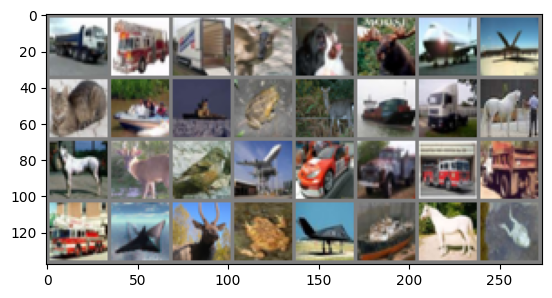

truck truck truck deer  dog   deer  plane plane cat   ship  ship  frog  deer  ship  truck horse horse deer  bird  plane car   truck truck truck truck plane deer  frog  plane ship  horse frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg19_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 2.300
[1,    40] loss: 2.305
[1,    60] loss: 2.305
[1,    80] loss: 2.302
[1,   100] loss: 2.302
[1,   120] loss: 2.303
[1,   140] loss: 2.307
[1,   160] loss: 2.303
[1,   180] loss: 2.305
[1,   200] loss: 2.307
[1,   220] loss: 2.304
[1,   240] loss: 2.305
[1,   260] loss: 2.301
[1,   280] loss: 2.301
[1,   300] loss: 2.304
[1,   320] loss: 2.305
[1,   340] loss: 2.304
[1,   360] loss: 2.303
[1,   380] loss: 2.304
[1,   400] loss: 2.303
[1,   420] loss: 2.305
[1,   440] loss: 2.304
[1,   460] loss: 2.302
[1,   480] loss: 2.305
[1,   500] loss: 2.303
[1,   520] loss: 2.304
[1,   540] loss: 2.303
[1,   560] loss: 2.306
[1,   580] loss: 2.304
[1,   600] loss: 2.301
[1,   620] loss: 2.302
[1,   640] loss: 2.303
[1,   660] loss: 2.304
[1,   680] loss: 2.299
[1,   700] loss: 2.304
[1,   720] loss: 2.307
[1,   740] loss: 2.303
[1,   760] loss: 2.303
[1,   780] loss: 2.307
[1,   800] loss: 2.302
[1,   820] loss: 2.303
[1,   840] loss: 2.304
[1,   860] loss: 2.306
[1,   880] 

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        x = x.view(-1, 16*5*5) # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

LeNet_model = LeNet()

# Generate a random tensor with shape [batch_size, channels, height, width]
random_input = torch.randn(5, 1, 32, 32)
output = LeNet_model(random_input)
print("Output shape:", output.shape)

Output shape: torch.Size([5, 10])


In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),)

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

AlexNet_model = AlexNet()

# Generate a random tensor with shape [batch_size, channels, height, width]
random_input = torch.randn(1, 3, 224, 224)
output = AlexNet_model(random_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1000])
